# imports and static stuff

In [1]:
%cd src

/home/evry/Desktop/master-degree/repositories/vision-anomaly/src


/home/evry/anaconda3/envs/vision-anomaly/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import cv2

from torchsummary import summary
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim import Adam

from model.model import Model

from src.data_loader.data_loader import MVTec
from progressbar import Bar, DynamicMessage, ProgressBar, ETA

from torchmetrics.image import StructuralSimilarityIndexMeasure
from torch.utils.data import random_split

In [3]:
print(torch.__version__)

2.3.0


In [4]:
import os

def save_comparison(class_name: str, file_name:str, image, mask, reconstruction, ssim_map, save_fig: bool, plot: bool):
    with torch.no_grad():
        _input_image = image.cpu().numpy()[0].transpose(1, 2, 0)
        _mask = mask.cpu().numpy()[0].transpose(1, 2, 0)
        _ssim_map = ssim_map.cpu().numpy()[0][0]

        # Normalize the SSIM map
        ssim_map_norm = (_ssim_map - _ssim_map.min()) / (_ssim_map.max() - _ssim_map.min())
        
        # Create a heatmap from the normalized SSIM map
        heatmap = cv2.applyColorMap((ssim_map_norm * 255).astype(np.uint8), cv2.COLORMAP_JET)

        # Convert _input_image to uint8
        _input_image_uint8 = _input_image_uint8 = (_input_image * 255).astype(np.uint8)

        # Overlay the heatmap on the original input image
        overlay = cv2.addWeighted(_input_image_uint8, 0.7, heatmap, 0.3, 0)

        # Plot the results

        fig = plt.figure(figsize=(10, 3))

        ax1 = fig.add_subplot(141)
        ax1.imshow(_input_image, cmap='gray')
        ax1.set_title('Input')
        
        reconstruction_norm = (reconstruction - reconstruction.min()) / (reconstruction.max() - reconstruction.min())
        
        ax2 = fig.add_subplot(142)
        ax2.imshow(reconstruction_norm.cpu().numpy()[0].transpose(1, 2, 0))
        ax2.set_title('Reconstructed')
        
        ax3 = fig.add_subplot(143)
        ax3.imshow(_mask, cmap='gray')
        ax3.set_title('GT')
        
        ax4 = fig.add_subplot(144)
        ax4.imshow(overlay)
        ax4.set_title('Pred')
        
        plt.tight_layout()
        if plot:
            plt.show()
        
        path = f"../runs/{class_name}/plots/"
        
        if not os.path.exists(path):
            os.makedirs(path)
        
        if save_fig:
            fig.savefig(path + file_name)        
        
        fig.clear()
        plt.close()
        plt.cla()
        plt.clf()

# Loading data

In [5]:
dataset_root_path = "/home/evry/Desktop/master-degree/repositories/two-stage-coarse-to-fine-image-anomaly-segmentation-and-detection-model/data/images"
# dataset_root_path = "/home/evry/Desktop/master-degree/dataset/BTech_Dataset_transformed"

def read_data(class_name: str, file_extension: str = "png"):
    train_dataset = MVTec(class_name=class_name, root_dir=dataset_root_path + f"/{class_name}", test=False, resize_shape=[256, 256], file_extension=file_extension)
    test_dataset = MVTec(class_name=class_name,root_dir=dataset_root_path + f"/{class_name}", test=True, resize_shape=[256, 256], file_extension=file_extension)

    train_loader = DataLoader(dataset = train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(dataset = test_dataset, batch_size=1, shuffle=True)
    
    return train_loader, test_loader

# Model training

- [ ] Test model after each epoch (remember to put model in train mode)
- [ ] Perform early stopping based on the model test

In [6]:
from sklearn.metrics import roc_auc_score
from torchmetrics.image import StructuralSimilarityIndexMeasure

def test(class_name: str, epoch: int, model: Model, test_loader: DataLoader, plot: bool = False, save_fig: bool = True):
    mse_sum = 0
    ssim_sum = 0
    loss_sum = 0

    anomaly_samples_saved = 0
    
    SSIM = StructuralSimilarityIndexMeasure(return_full_image=True).cpu()
    
    model.eval()
    
    ssim_maps_list = []
    ground_truth_list = []
    
    for i, (input_batch, mask_batch, has_anomaly_batch) in enumerate(test_loader):
        _, reconstruction = model(input_batch.cuda())
        
        mse = F.mse_loss(reconstruction.cpu(), input_batch.cpu(), reduction='mean')
            
        mse_sum += mse.item()
        
        ssim_value, ssim_map = SSIM(input_batch.cpu(), reconstruction.cpu())
        
        ssim_sum += ssim_value.item()
        
        loss_sum += mse.item() + (1.0 - ssim_value.item())
        
        if has_anomaly_batch[0] and anomaly_samples_saved < 1:
            save_comparison(
                class_name,
                f"anomaly_sample_epoch_{epoch}.jpg",
                input_batch,
                mask_batch,
                reconstruction,
                ssim_map,
                save_fig,
                plot
            )
            
            anomaly_samples_saved += 1
            
        if has_anomaly_batch[0]:
            anomaly_score_map = 1 - ssim_map.cpu().detach().numpy()
            ssim_maps_list.append(anomaly_score_map.flatten())
            
            binary_ground_truth = (mask_batch.cpu().detach().numpy() > 0).astype(int)
            ground_truth_list.append(binary_ground_truth.flatten())
            
    model.train()
    
    # Flatten the lists of arrays
    ssim_maps_array = np.concatenate(ssim_maps_list)
    ground_truth_array = np.concatenate(ground_truth_list)
    
    # Calculate the ROC-AUC
    auc_score = roc_auc_score(ground_truth_array, ssim_maps_array)
    
    batches = test_loader.__len__()
    
    return mse_sum / batches, ssim_sum / batches, loss_sum / batches, auc_score

In [7]:
def train(class_name: str, model_depth=16, model_patch_size=32):
    print(f"\n\nStart training for object \"{class_name}\"\n\n\n")
    
    progressbar_widgets = [
        DynamicMessage('log', format = '{formatted_value}'),
        Bar(marker='=', left='[', right=']'),
        ' ',  ETA(),
    ]

    SSIM = StructuralSimilarityIndexMeasure().cuda()
    
    best_epoch = -1
    best_loss = 1e10
    epochs = 400
    
    train_loader, test_loader = read_data(class_name)
    
    model = Model(patch_size=model_patch_size, depth=model_depth).cuda()
    model.train()

    # print(summary(model, (3, 256, 256)))
    
    summary_writer = SummaryWriter(log_dir=f'../runs/{class_name}')

    optimizer = Adam(list(model.parameters()), lr=0.0001, weight_decay=0.0001)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer,[epochs*0.4, epochs*0.7],gamma=0.1, last_epoch=-1)

    for epoch in range(epochs):
        train_mse_losses = 0.0
        train_ssim_losses = 0.0
        train_losses = 0.0
        
        with ProgressBar(widgets=progressbar_widgets, max_value=train_loader.__len__() + 1) as progress_bar:
            for sample_i, (input_batch, mask_batch, _) in enumerate(train_loader):
                model.zero_grad()
                
                input_batch = input_batch.cuda()
                
                _, reconstruction = model(input_batch)
                
                reconstruction = reconstruction.cuda()
                # print(f"Recon shape: {reconstruction.shape}")
                mse = F.mse_loss(reconstruction, input_batch, reduction='mean')
                
                train_mse_losses += mse.item()
                
                ssim_value = SSIM(input_batch.cuda(), reconstruction)
                
                train_ssim_losses += ssim_value.item()
                
                loss = mse.item() + (1.0 - ssim_value.item())
                
                train_losses += loss

                mse.backward()
                
                optimizer.step()                
                
                progress_bar.update(
                                sample_i,
                                log=f"({epoch+1}/{epochs}) MSE: {mse:.4f} SSIM: {ssim_value:.4f} Loss: {loss:.4f}")

            batches = train_loader.__len__()
            
            train_mse = train_mse_losses / batches
            train_ssim = train_ssim_losses / batches
            train_loss = train_losses / batches

            summary_writer.add_scalar('train_mse', train_mse, epoch)
            summary_writer.add_scalar('train_ssim', train_ssim, epoch)
            summary_writer.add_scalar('train_loss', train_loss, epoch)
            
            log = f"({epoch+1}/{epochs}) MSE: {train_mse:.4f} SSIM: {train_ssim:.4f} Loss: {train_loss:.4f}"
            
            test_mse, test_ssim, test_loss, test_auc_score = test(class_name, epoch, model, test_loader, save_fig=epoch % 5 == 0)
            
            summary_writer.add_scalar('test_mse', test_mse, epoch)
            summary_writer.add_scalar('test_ssim', test_ssim, epoch)
            summary_writer.add_scalar('test_loss', test_loss, epoch)
            summary_writer.add_scalar('test_auc', test_auc_score, epoch)
            
            log += f" | Test MSE: {test_mse:.4f} Test SSIM: {test_ssim:.4f} Test AUC: {test_auc_score:.4f} Test Loss: {test_loss:.4f} Best loss: {best_loss:.4f} ({best_epoch})"      
                    
            progress_bar.update(batches, log=log)

        scheduler.step()

        if test_loss < best_loss and best_loss - test_loss >= 0.01:
            best_epoch = epoch
            best_loss = test_loss
            
            torch.save(model.state_dict(), f'../vit_models/vit_{class_name}.pt')
        elif epoch - best_epoch >= 50:
            print("\n\n==========================================================================================")
            print(f"Stopping training for object {class_name}. No improvements since epoch {best_epoch}")
            print("==========================================================================================")
            
            break
        
    del model
    del optimizer
                

In [8]:
model_depth = 16
model_patch_size = 32

# classes = ['01', '02', '03']
# classes = ['bottle','cable','capsule','carpet','grid','hazelnut','leather','metal_nut','pill','screw','tile','toothbrush','transistor','wood','zipper']
classes = ['zipper']

for class_name in classes:
    train(class_name, model_depth=model_depth)



Start training for object "zipper"





/home/evry/anaconda3/envs/vision-anomaly/lib/python3.12/site-packages/torch/nn/modules/conv.py:952: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1712609048481/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv_transpose2d(
(1/400) MSE: 0.3868 SSIM: 0.0177 Loss: 1.3691 | Test MSE: 0.2857 Test SSIM: -0.0021 Test AUC: 0.4912 Test Loss: 1.2878 Best loss: 10000000000.0000 (-1)[] Time:  0:00:14
(2/400) MSE: 0.3262 SSIM: 0.0587 Loss: 1.2675 | Test MSE: 0.2816 Test SSIM: 0.0544 Test AUC: 0.5244 Test Loss: 1.2272 Best loss: 1.2878 (0)[] Time:  0:00:14
(3/400) MSE: 0.3077 SSIM: 0.0886 Loss: 1.2192 | Test MSE: 0.2903 Test SSIM: 0.0901 Test AUC: 0.5383 Test Loss: 1.2002 Best loss: 1.2272 (1)[] Time:  0:00:14
(4/400) MSE: 0.2945 SSIM: 0.0988 Loss: 1.1957 | Test MSE: 0.2874 Test SSIM: 0.1037 Test AUC: 0.5452 Test Loss: 1.1837 Best loss: 1.2002 (2)[] Time:  0:00:14
(5/400) MSE: 0.2838 SSIM: 0.1132 Loss: 1.1707 | 

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

# Loading saved model and testing it

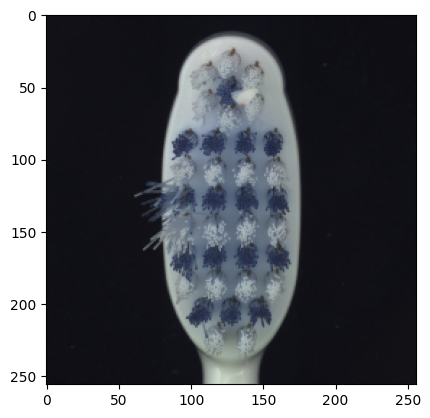

In [ ]:
class_name = "zipper"

model = Model(patch_size=model_patch_size, depth=model_depth).cuda()

model.load_state_dict(torch.load(f'../vit_models/vit_{class_name}.pt'))

model.eval()

_, test_loader = read_data(class_name)

test_image, mask, has_anomaly = test_loader.dataset.__getitem__(0)

test_image = test_image.unsqueeze(0).cuda()

plt.imshow(test_image.cpu().numpy()[0].transpose(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.081278..5.1962986].


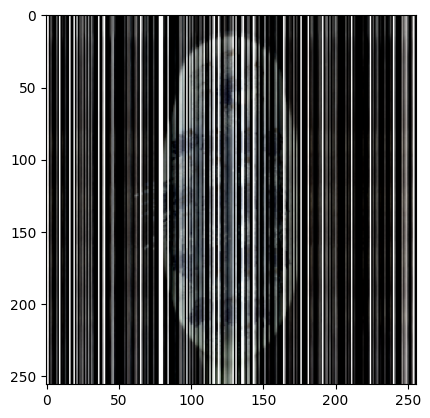

In [ ]:
# mask = model.mask

output = model.vit.transformer(test_image.cuda()[0])

with torch.no_grad():
    plt.imshow(output.cpu().numpy().transpose(1, 2, 0))

In [ ]:
SSIM = StructuralSimilarityIndexMeasure(return_full_image=True).cpu()

encoded, reconstruction = model(test_image)

mse = F.mse_loss(reconstruction, test_image, reduction='mean')
ssim_value, ssim_map = SSIM(reconstruction.cpu(), test_image.cpu())

mse.item(), ssim_value.item()

(0.006113340612500906, 0.8349831104278564)

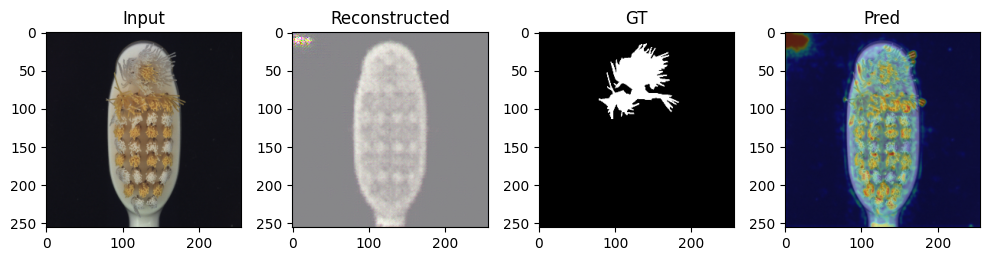

(0.005815739876457623,
 0.8321882628259205,
 0.17362747705053716,
 0.9240475679262674)

<Figure size 640x480 with 0 Axes>

In [ ]:
test(class_name, -1, model, test_loader, save_fig=False, plot=True)

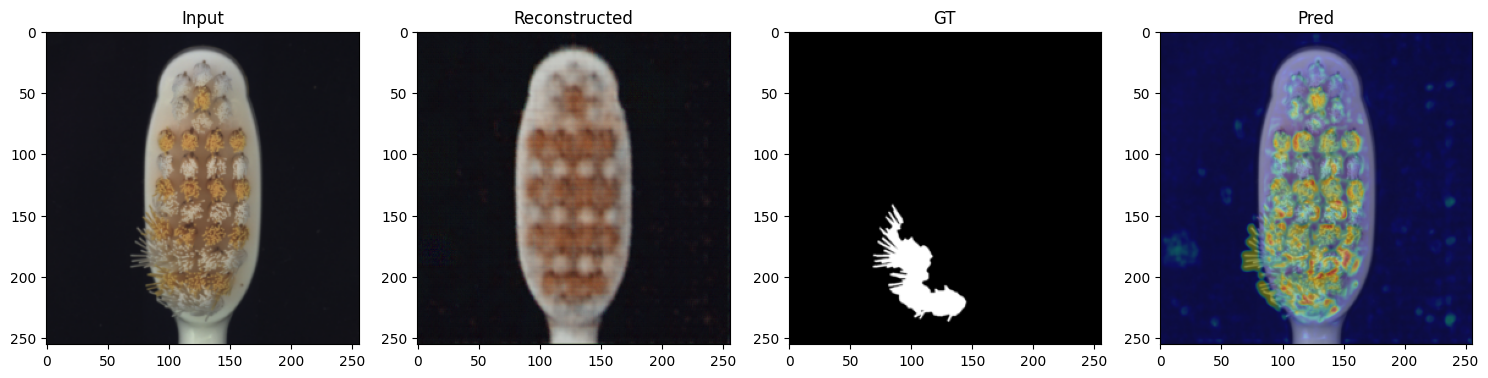